# Efstathios Chatziloizos - SAX paper experiment replication
[A Symbolic Representation of Time Series, with Implications for
Streaming Algorithms](https://www.cs.ucr.edu/~eamonn/SAX.pdf)

### Load [Control Chart dataset](https://archive.ics.uci.edu/dataset/139/synthetic+control+chart+time+series)

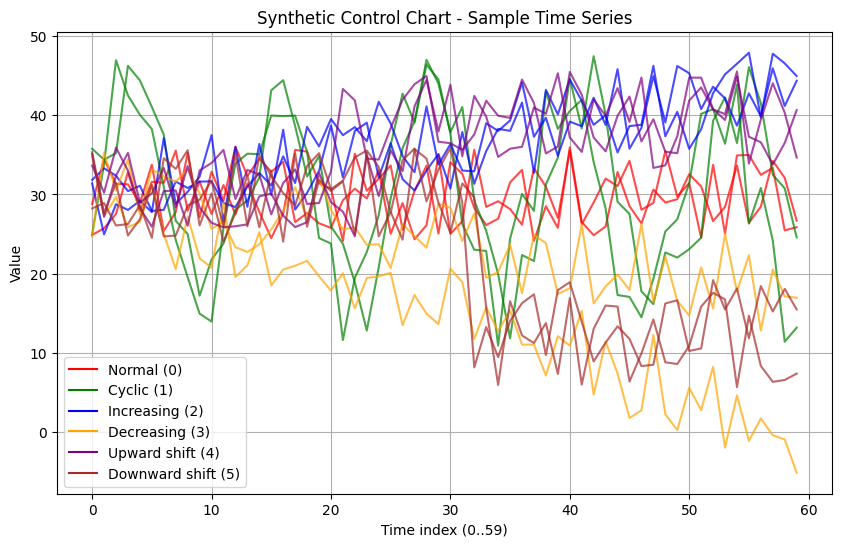

In [2]:
import math
from scipy.stats import norm
import matplotlib.pyplot as plt


def load_synthetic_control(filename):
    """
    Loads the Synthetic Control Chart dataset from a text file.
    Each of the 600 lines has 60 space-separated floats.
    Classes (in order):
        0: normal        (lines 0..99)
        1: cyclic        (lines 100..199)
        2: increasing    (lines 200..299)
        3: decreasing    (lines 300..399)
        4: upward shift  (lines 400..499)
        5: downward shift(lines 500..599)
    Returns:
        X: list of lists (600 x 60) of floats
        y: list of int (600)
    """
    X, y = [], []
    with open(filename, 'r') as f:
        lines = f.readlines()

    for idx, line in enumerate(lines):
        values = list(map(float, line.strip().split()))
        X.append(values)
        label = idx // 100
        y.append(label)
    return X, y


X, y = load_synthetic_control("datasets/synthetic_control.data")

samples_per_class = 2

# We'll store color or style for each class
colors = ["red", "green", "blue", "orange", "purple", "brown"]
class_names = [
    "Normal (0)",
    "Cyclic (1)",
    "Increasing (2)",
    "Decreasing (3)",
    "Upward shift (4)",
    "Downward shift (5)",
]

plt.figure(figsize=(10, 6))

for c in range(6):
    # Find indices of items that belong to class c
    indices_c = [i for i, label in enumerate(y) if label == c]
    # Take just a few
    for idx in indices_c[:samples_per_class]:
        plt.plot(X[idx], label=f"Class {c}", color=colors[c], alpha=0.7)

plt.title("Synthetic Control Chart - Sample Time Series")
plt.xlabel("Time index (0..59)")
plt.ylabel("Value")

handles = []
for c in range(6):
    line = plt.Line2D([], [], color=colors[c], label=class_names[c])
    handles.append(line)
plt.legend(handles=handles)
plt.grid(True)
plt.show()

----------

### SAX implementation

In [3]:
def compute_breakpoints(max_a):
    """
    Compute breakpoints for Gaussian distribution to ensure equiprobable regions for SAX discretization.
    Returns a dictionary where keys are alphabet sizes and values are lists of breakpoints.
    """
    breakpoints = {}
    for a in range(3, max_a + 1):
        breakpoints[a] = [norm.ppf(i / a) for i in range(1, a)]
    return breakpoints

# Precompute breakpoints for Gaussian distribution, ensuring equiprobable regions for SAX discretization.
BREAKPOINTS = compute_breakpoints(32) # allow up to a 32-letter alphabet


def euclidean_distance(a, b):
    """Compute Euclidean distance between two lists a and b."""
    return math.dist(a, b)

def z_normalize(ts):
    """Z-normalize a time series ts (list of floats)."""
    n = len(ts)
    mean_val = sum(ts) / n
    sq_sum = sum((val - mean_val)**2 for val in ts)
    std_val = math.sqrt(sq_sum / n)
    if std_val < 1e-12:
        return [0.0] * n
    return [(val - mean_val) / std_val for val in ts]

def paa(ts, w):
    """
    Piecewise Aggregate Approximation of ts into w segments.
    Assumes len(ts) is divisible by w for simplicity.
    """
    n = len(ts)
    step = n // w
    return [sum(ts[i*step:(i+1)*step]) / step for i in range(w)]

def ts_to_sax(ts, w, a):
    """
    Convert a time series ts to SAX:
      1) Z-normalize
      2) PAA of length w
      3) Map each segment to a symbol in [0..a-1]
    """
    znorm = z_normalize(ts)
    paa_vals = paa(znorm, w)
    bpts = BREAKPOINTS[a]
    symbols = []
    for val in paa_vals:
        symbol = 0
        while symbol < a - 1 and val > bpts[symbol]:
            symbol += 1
        symbols.append(symbol)
    return symbols

def symbolic_dist(sym_i, sym_j, breakpoints):
    """
    Distance between two symbols sym_i, sym_j in SAX.
    If gap == 0 or 1 => 0, else difference of breakpoints.
    """
    if sym_i == sym_j:
        return 0.0
    gap = abs(sym_i - sym_j)
    if gap == 1:
        return 0.0
    left = min(sym_i, sym_j)
    right = max(sym_i, sym_j)
    return breakpoints[right - 1] - breakpoints[left]

def sax_mindist(sax_word1, sax_word2, a, original_length, w):
    """
    Lower-bound distance between two SAX words, as per the SAX paper.
    MINDIST = sqrt( (original_length / w) * sum(symbolic_dist^2 ) ).
    """
    bpts = BREAKPOINTS[a]
    sum_sq = 0.0
    for i in range(w):
        d = symbolic_dist(sax_word1[i], sax_word2[i], bpts)
        sum_sq += d * d
    return math.sqrt((original_length / w) * sum_sq)


-------

## Hierarchical Clustering (Section 4.1 of the paper)

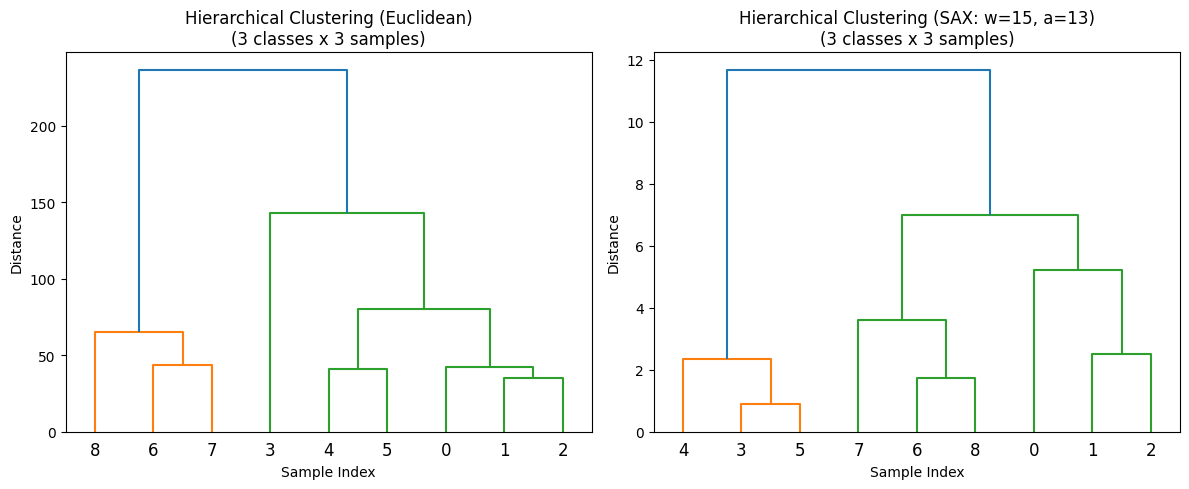

In [4]:
import scipy.cluster.hierarchy as sch

def compute_distance_matrix(data, dist_func):
    """
    Given a list of items `data` (each item is a time series or SAX word),
    and a distance function dist_func(i, j) => float,
    build an NxN distance matrix in the form required by `scipy`.
    """
    n = len(data)
    # Build a 1D array of size n*(n-1)/2 in row-major (condensed) form
    # First fill up a standard NxN matrix, then convert with squareform.
    dist_mat = [[0.0]*n for _ in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            d = dist_func(data[i], data[j])
            dist_mat[i][j] = d
            dist_mat[j][i] = d
    # Convert NxN -> condensed
    # squareform wants a 1D list of upper-triangular values
    condensed = []
    for i in range(n):
        for j in range(i+1, n):
            condensed.append(dist_mat[i][j])
    return condensed

def hierarchical_clustering_euclidean(X_sub):
    """
    Perform hierarchical clustering (complete linkage) using
    Euclidean distance on a subset X_sub of time series.
    Returns the linkage matrix Z from scipy.
    """
    # Build condensed distance array
    dist_condensed = compute_distance_matrix(X_sub, euclidean_distance)
    Z = sch.linkage(dist_condensed, method='complete')
    return Z

def hierarchical_clustering_sax(X_sub, w, a):
    """
    Perform hierarchical clustering (complete linkage) using
    SAX MINDIST on a subset X_sub of time series.
    Returns the linkage matrix Z from scipy.
    """
    # Convert time series to SAX
    original_length = len(X_sub[0])  # 60 for control chart
    sax_data = [ts_to_sax(ts, w, a) for ts in X_sub]

    # Store indices
    indices = list(range(len(sax_data)))

    def sax_index_dist(i_idx, j_idx):
        return sax_mindist(sax_data[i_idx], sax_data[j_idx], a, original_length, w)

    dist_condensed = compute_distance_matrix(indices, sax_index_dist)
    Z = sch.linkage(dist_condensed, method='complete')
    return Z

# Load the data
X, y = load_synthetic_control("datasets/synthetic_control.data")

# Pick 9 series (3 from each of these classes: normal=0, decreasing=3, upward shift=4) (as per the paper)
desired_classes = [0, 3, 4]  # normal, decreasing, upward shift

X_sub, y_sub = [], []
for c in desired_classes:
    # get indices for class c
    indices_c = [i for i, label in enumerate(y) if label == c]
    # take first 3
    for idx in indices_c[:3]:
        X_sub.append(X[idx])
        y_sub.append(y[idx])

# Hierarchical clustering with Euclidean
Z_euc = hierarchical_clustering_euclidean(X_sub)

# Hierarchical clustering with SAX
# The paper doesn't specify the exact w/a used for that dendrogram,
w = 15
a = 13
Z_sax = hierarchical_clustering_sax(X_sub, w, a)

# Plot side-by-side dendrograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Euclidean
sch.dendrogram(Z_euc, ax=axes[0])
axes[0].set_title("Hierarchical Clustering (Euclidean)\n(3 classes x 3 samples)")

# Right: SAX
sch.dendrogram(Z_sax, ax=axes[1])
axes[1].set_title(f"Hierarchical Clustering (SAX: w={w}, a={a})\n(3 classes x 3 samples)")

for ax in axes:
    ax.set_ylabel("Distance")
    ax.set_xlabel("Sample Index")

plt.tight_layout()
plt.show()

------

## Classification with SAX
### 1 Nearest Neighbor Classification (Section 4.2.1 of the paper)

In [5]:
def do_1nn_sax(X, y, w, a):
    """
    1-NN classification using the SAX MINDIST (Leave-One-Out).
    Returns accuracy in [0..1].
    """
    original_length = len(X[0])
    sax_data = [ts_to_sax(ts, w, a) for ts in X]
    correct = 0
    total = len(X)
    for i in range(total):
        best_dist = float('inf')
        best_label = None
        for j in range(total):
            if i == j:
                continue
            dist = sax_mindist(sax_data[i], sax_data[j], a, original_length, w)
            if dist < best_dist:
                best_dist = dist
                best_label = y[j]
        if best_label == y[i]:
            correct += 1
    return correct / total  # fraction of correct classifications

def do_1nn_euclidean(X, y):
    """
    Performs 1-NN classification using Euclidean distance (Leave-One-Out).
    Returns the accuracy as a fraction in [0..1].
    """
    correct = 0
    total = len(X)
    for i in range(total):
        best_dist = float('inf')
        best_label = None
        for j in range(total):
            if i == j:
                continue
            dist = euclidean_distance(X[i], X[j])
            if dist < best_dist:
                best_dist = dist
                best_label = y[j]
        if best_label == y[i]:
            correct += 1
    return correct / total  # e.g. 0.95 means 95% accuracy

# Load the Control Chart dataset
X, y = load_synthetic_control("datasets/synthetic_control.data")

# Euclidean error rate (constant for all a)
frac_acc_euc = do_1nn_euclidean(X, y)
error_euc = 1 - frac_acc_euc
print(f"Euclidean Error Rate: {error_euc:.3f}")

# For SAX, we fix w=15 (4:1 dimension reduction from 60) as mentioned in the paper.
w = 15

# Run SAX for best found parameters of a = 13 and w = 15.
a = 13
frac_acc_sax = do_1nn_sax(X, y, w, a)
error_sax = 1 - frac_acc_sax

print(f"SAX Error Rate (w={w}, a={a}): {error_sax:.3f}")

Euclidean Error Rate: 0.013
SAX Error Rate (w=15, a=13): 0.007


-----

### Recreate Figure 13 of the paper for the Control Chart dataset

The experiment is extended for alphabet sizes larger than 10


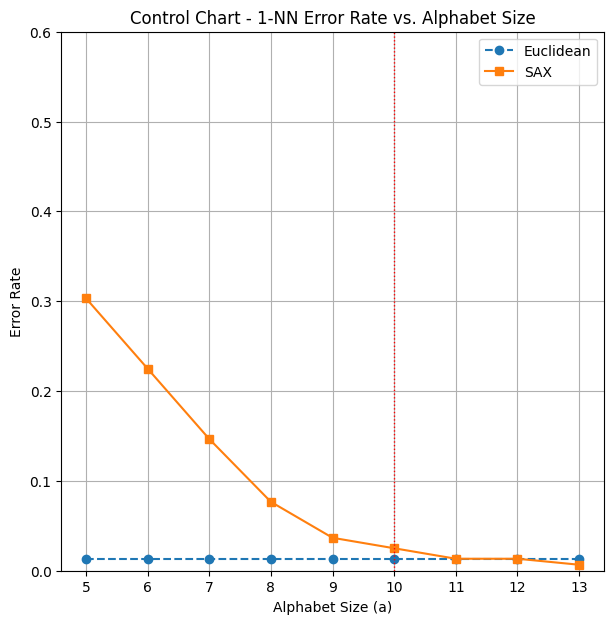

In [6]:
acc_euc = do_1nn_euclidean(X, y)
error_euclidean = 1 - acc_euc

w = 15
sax_error_rates = []
alphabet_sizes = range(5, 14)

for a in alphabet_sizes:
    acc_sax = do_1nn_sax(X, y, w, a)
    error_sax = 1 - acc_sax
    sax_error_rates.append(error_sax)


plt.figure(figsize=(7, 7))
# Euclidean: just one horizontal line
plt.plot(alphabet_sizes, [error_euclidean]*len(alphabet_sizes),
            label="Euclidean", marker='o', linestyle='--')

# SAX line
plt.plot(alphabet_sizes, sax_error_rates, label="SAX", marker='s')
plt.axvline(x=10, color='red', linestyle=':', linewidth=1)

plt.title("Control Chart - 1-NN Error Rate vs. Alphabet Size")
plt.xlabel("Alphabet Size (a)")
plt.ylabel("Error Rate")
plt.ylim(0, 0.6)  # error rates from 0 to 0.6 as in the paper
plt.grid(True)
plt.legend()
plt.show()

-----

## Query by Content (Indexing) with SAX (Section 4.3 of the paper)

### Indexing on the Control Chart dataset

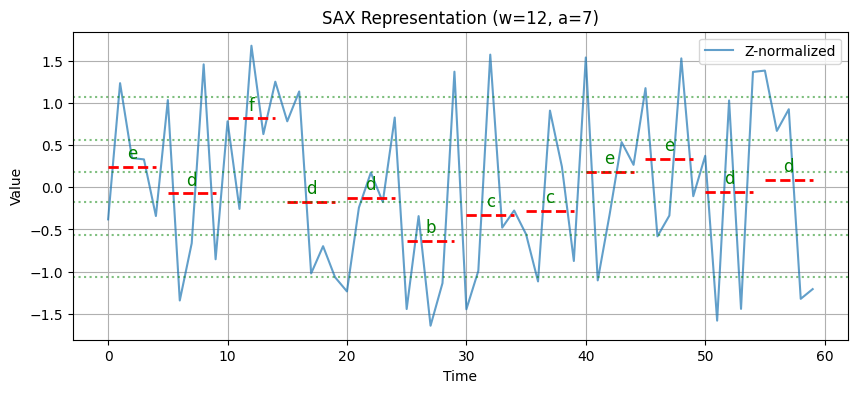

SAX-based NN accuracy: 92.50%


In [7]:
import math
import matplotlib.pyplot as plt

def sax_query(query_ts, X, y, w, a, k=10):
    """
    Find the nearest neighbor for `query_ts` using SAX-based candidate pruning.
    """
    # Convert entire dataset to SAX
    sax_data = [ts_to_sax(ts, w, a) for ts in X]
    query_sax = ts_to_sax(query_ts, w, a)
    original_length = len(query_ts)
    
    # Compute MINDIST between query and all SAX words
    mindist = []
    for sax_word in sax_data:
        dist = sax_mindist(query_sax, sax_word, a, original_length, w)
        mindist.append(dist)
    
    # Get indices of top `k` candidates based on MINDIST
    top_k_indices = sorted(range(len(mindist)), key=lambda i: mindist[i])[:k]
    
    # Refine with actual Euclidean distance on original data
    query_znorm = z_normalize(query_ts)
    min_euc = float('inf')
    best_idx = -1
    for idx in top_k_indices:
        candidate_znorm = z_normalize(X[idx])
        dist = euclidean_distance(query_znorm, candidate_znorm)
        if dist < min_euc:
            min_euc = dist
            best_idx = idx
    
    return best_idx, min_euc

# Load the Synthetic Control dataset
X, y = load_synthetic_control("datasets/synthetic_control.data")

# Pick a sample time series (e.g., first "Normal" class)
sample_ts = X[0]

# SAX parameters
w = 12
a = 7

# Z-normalize the sample
znorm = z_normalize(sample_ts)

# Compute PAA
paa_vals = paa(znorm, w)

# Convert PAA to SAX symbols
sax_symbols = ts_to_sax(sample_ts, w, a)

# Map symbols to letters (0->a, 1->b, etc.)
sax_letters = [chr(ord('a') + s) for s in sax_symbols]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(znorm, label="Z-normalized", alpha=0.7)

# Plot PAA segments
step = len(znorm) // w
for i in range(w):
    start = i * step
    end = (i+1) * step
    plt.hlines(paa_vals[i], start, end-1, colors='red', linestyles='dashed', linewidth=2)

# Annotate SAX symbols
for i in range(w):
    x_pos = (i * step) + (step // 2)
    plt.text(x_pos, paa_vals[i] + 0.1, sax_letters[i], ha='center', color='green', fontsize=12)

# Plot breakpoints
breakpoints = BREAKPOINTS[a]
for bp in breakpoints:
    plt.axhline(bp, color='green', linestyle='dotted', alpha=0.5)

plt.title(f"SAX Representation (w={w}, a={a})")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Query all time series and keep statistics of how many it got right
correct_sax = 0

for i in range(len(X)):
    query = X[i]
    best_idx, sax_dist = sax_query(query, X, y, w=w, a=a, k=10)
    
    if y[best_idx] == y[i]:
        correct_sax += 1

print(f"SAX-based NN accuracy: {correct_sax / len(X) * 100:.2f}%")

-----

## Lower bounding Demo

In [8]:
import math
import random
import numpy as np
import time

# Setup: Synthetic dataset + Query

def generate_synthetic_dataset(n_series=200, length=60, seed=42):
    """
    Generate a random dataset of n_series time series, each of given length.
    We'll also assign a random 'class' label just for demonstration.
    """
    random.seed(seed)
    np.random.seed(seed)
    
    X = []
    y = []
    for i in range(n_series):
        # Create a random walk or random time series
        ts = np.cumsum(np.random.randn(length))
        X.append(ts)
        y.append(i % 3)  # example label
    return X, y

# 1-NN with Euclidean distance (full scan - always read from disk)
def one_nn_euclidean_full_scan(query_ts, dataset):
    """
    Naive 1-NN with Euclidean distance.
    We simulate that each time we check a candidate, we do 1 disk read.
    Returns (best_index, best_dist, disk_reads).
    """
    best_idx = -1
    best_dist = float('inf')
    disk_reads = 0
    query_znorm = z_normalize(query_ts)
    
    for i, ts in enumerate(dataset):
        # Simulate reading from disk
        disk_reads += 1
        
        candidate_znorm = z_normalize(ts)
        dist = euclidean_distance(query_znorm, candidate_znorm)
        if dist < best_dist:
            best_dist = dist
            best_idx = i
    return best_idx, best_dist, disk_reads

# SAX-based pruning: keep SAX in memory, only read from disk if MINDIST is < best_dist_so_far.
def one_nn_sax_pruning(query_ts, dataset, sax_dataset, w, a):
    """
    Single-level SAX approach.
      1) Convert query_ts to SAX
      2) For each candidate's SAX, compute MINDIST
      3) If MINDIST < best_dist, read from disk => compute real Eucl dist
    Returns (best_idx, best_dist, disk_reads, pruned_count).
    pruned_count: how many were pruned by MINDIST alone (no disk read).
    """
    query_sax = ts_to_sax(query_ts, w, a)
    query_znorm = z_normalize(query_ts)
    best_idx = -1
    best_dist = float('inf')
    disk_reads = 0
    pruned_count = 0  # how many we can prune due to MINDIST >= best_dist
    
    for i, sax_word in enumerate(sax_dataset):
        dist_lb = sax_mindist(query_sax, sax_word, a, orig_len, w)
        if dist_lb < best_dist:
            disk_reads += 1
            candidate_znorm = z_normalize(dataset[i])
            dist = euclidean_distance(query_znorm, candidate_znorm)
            if dist < best_dist:
                best_dist = dist
                best_idx = i
        else:
            # pruned by MINDIST
            pruned_count += 1
    
    return best_idx, best_dist, disk_reads, pruned_count


# Demo: Compare 1-NN with Euclidean vs. SAX-based pruning
def demo_comparison(num_queries=10, track_latency=None):
    """
    Dor random queries from X, do:
      - Full Euclidean 1-NN
      - Single-level SAX 1-NN
    Compute stats and print.
    """
    # Randomly pick some queries
    indices = random.sample(range(len(X)), num_queries)
    
    # We accumulate stats
    total_disk_euclid = 0
    total_disk_sax = 0

    # Time
    euclid_time = 0
    sax_time = 0

    # Latency: 12ms per disk read and 100 microsec for ssd
    hdd_latency = 0.012  # 12ms in seconds
    ssd_latency = 0.0001  # 100 microsec in seconds
    latency_euclid = 0
    latency_sax = 0
    
    correct_matches = 0  # optional: how often they pick the same best index
    for q_idx in indices:
        q_ts = X[q_idx]
        
        # Full Euclidean
        start_time = time.time()
        e_idx, e_dist, e_reads = one_nn_euclidean_full_scan(q_ts, X)
        euclid_time += time.time() - start_time

        # SAX-based
        start_time = time.time()
        s_idx, s_dist, s_reads, pruned_count = one_nn_sax_pruning(q_ts, X, sax_data, w, a)
        sax_time += time.time() - start_time

        # Add the would-be latency for disk reads
        if track_latency == 'hdd':
            latency_euclid += e_reads * hdd_latency
            latency_sax += s_reads * hdd_latency
        else:
            latency_euclid+= e_reads * ssd_latency
            latency_sax += s_reads * ssd_latency
        
        
        total_disk_euclid += e_reads
        total_disk_sax += s_reads
        
        if e_idx == s_idx:
            correct_matches += 1

    if track_latency:        
        # Add latency to total time
        euclid_time += latency_euclid
        sax_time += latency_sax

    
    avg_euclid = total_disk_euclid / num_queries
    avg_sax = total_disk_sax / num_queries
    same_nn_rate = correct_matches / num_queries
    if same_nn_rate != 1:
        # Sanity check that there is not bug in the code (they should always pick the same best index)
        print(f"Warning: Not all queries found the same best index.")
    
    print(f"-- Results over {num_queries} queries (track_latency={track_latency}) --")
    if track_latency:
        print(f"  Full Euclidean: avg disk reads = {avg_euclid:.2f}\t time = {euclid_time:.2f}s, of which {latency_euclid:.2f}s is {track_latency} access latency ({(latency_euclid/euclid_time)*100:.2f})%")
        print(f"  SAX-based:      avg disk reads = {avg_sax:.2f}\t time = {sax_time:.2f}s, of which {latency_sax:.2f}s is {track_latency} access latency ({(latency_sax/sax_time)*100:.2f})%")
    else:
        print(f"  Full Euclidean: avg disk reads = {avg_euclid:.2f}\t time = {euclid_time:.2f}s")
        print(f"  SAX-based:      avg disk reads = {avg_sax:.2f}\t time = {sax_time:.2f}s")
    print(f"  SAX pruned {pruned_count} candidates, or {(pruned_count / (avg_sax + pruned_count)) * 100:.2f}% of total candidates")
    print(f"  Time reduction: {(1 - (sax_time / euclid_time)) * 100:.2f}% and latency reduction: {(1- (latency_sax / latency_euclid)) * 100:.2f}%")

    # Dimensinality reduction from real-valued time series to SAX words
    quotient = len(X[0]) / w
    formatted_quotient = f"{int(quotient)}" if quotient.is_integer() else f"{quotient:.1f}"
    print(f"Dimensionality reduction: {len(X[0])} -> {w}, so {formatted_quotient} to 1")


# Generate Data
X, y = generate_synthetic_dataset(n_series=50000, length=600, seed=42)


# Parameters for SAX
w = 15
a = 10
orig_len = len(X[0])

# Precompute the SAX words for the entire dataset
sax_data = [ts_to_sax(ts, w, a) for ts in X]

# Run a small demo, NOTE: to track latency, use track_latency='hdd' or 'ssd', default is None
demo_comparison(num_queries=1, track_latency='ssd')


-- Results over 1 queries (track_latency=ssd) --
  Full Euclidean: avg disk reads = 50000.00	 time = 17.94s, of which 5.00s is ssd access latency (27.87)%
  SAX-based:      avg disk reads = 4239.00	 time = 1.75s, of which 0.42s is ssd access latency (24.23)%
  SAX pruned 45761 candidates, or 91.52% of total candidates
  Time reduction: 90.25% and latency reduction: 91.52%
Dimensionality reduction: 600 -> 15, so 40 to 1


----

## EXTRA: Two‐Level SAX Approach for Indexing


In many scenarios, using a single SAX representation may still lead to a relatively large number of disk reads (refinement steps). To reduce these further, we tried out a two‐level SAX approach whose idea is to use a very coarse SAX representation to prune many candidates early on, before refining the distance estimate with a more detailed SAX representation.

1. **Coarse Representation**  
   We choose a smaller $w_{coarse}$ (number of PAA segments) and a smaller $\alpha_{coarse}$(alphabet size) to create a very compressed symbolic approximation.
   - This coarse representation is very cheap to store in memory and to compare (MINDIST is computed quickly).
   - It can prune many obviously distant candidates early on, without any disk reads.

2. **Refined Representation**  
  If a candidate time series survives the coarse check, we then compare it with a refined SAX representation, using larger $w_{fine}$ and $\alpha_{fine}$.
   - This yields a tighter MINDIST bound, pruning borderline candidates that the coarse representation could not confidently eliminate.
   - Still, no disk reads have happened yet for those pruned at this stage.

1. **Final Euclidean Check**  
   Only if the refined MINDIST is still below the best distance so far do we fetch the candidate’s raw time series from disk and compute the actual Euclidean distance. For a good choice of **Refined Representation** only a small fraction of candidates will make it to this final step, saving significant I/O and time.

In [9]:
def one_nn_sax_twolevel(query_ts, dataset, sax_data_coarse, w_coarse, a_coarse, sax_data_fine, w_fine, a_fine, orig_len):
    """
    Two-level SAX approach:
      1) Coarse MINDIST => prune quickly with smaller (w_coarse, a_coarse)
      2) If passes, refine with MINDIST_fine => (w_fine, a_fine)
      3) If still passes, read from disk => full Eucl dist
    Returns (best_idx, best_dist, disk_reads, coarse_pruned_count, fine_pruned_count).
    """
    query_sax_coarse = ts_to_sax(query_ts, w_coarse, a_coarse)
    query_sax_fine   = ts_to_sax(query_ts, w_fine,   a_fine)
    query_znorm      = z_normalize(query_ts)
    
    best_idx = -1
    best_dist = float('inf')
    disk_reads = 0
    
    coarse_pruned_count = 0
    fine_pruned_count   = 0
    
    for i in range(len(dataset)):
        # Coarse MINDIST
        dist_lb_coarse = sax_mindist(query_sax_coarse, sax_data_coarse[i], a_coarse, orig_len, w_coarse)
        if dist_lb_coarse >= best_dist:
            # Prune: no disk read
            coarse_pruned_count += 1
            continue
        
        # Fine MINDIST
        dist_lb_fine = sax_mindist(query_sax_fine, sax_data_fine[i], a_fine, orig_len, w_fine)
        if dist_lb_fine >= best_dist:
            # Prune: no disk read
            fine_pruned_count += 1
            continue
        
        # Still promising => do real Euclidean => 1 disk read
        disk_reads += 1
        candidate_znorm = z_normalize(dataset[i])
        dist = euclidean_distance(query_znorm, candidate_znorm)
        if dist < best_dist:
            best_dist = dist
            best_idx = i
    
    return best_idx, best_dist, disk_reads, coarse_pruned_count, fine_pruned_count

# Demo comparison of 1-NN with Euclidean vs. Single-level vs. Two-level SAX
def demo_comparison(num_queries=5, track_latency=None):
    """
    For random queries from X, do:
      - Full Euclidean 1-NN
      - Single-level SAX 1-NN
      - Two-level SAX 1-NN
    Compute stats and print.
    """
    indices = random.sample(range(len(X)), num_queries)
    
    # Stats
    total_disk_euclid = 0
    total_disk_sax_single = 0
    total_disk_sax_two = 0

    # For time
    euclid_time = 0
    sax_single_time = 0
    sax_two_time = 0

    # For latency
    hdd_latency = 0.012  # 12ms in seconds
    ssd_latency = 0.0001 # 100 microseconds in seconds
    lat_euclid = 0
    lat_sax_single = 0
    lat_sax_two = 0

    # For correctness checks
    correct_single = 0
    correct_two = 0

    # For pruning stats
    # Single-level: we track how many we skip from MINDIST
    pruned_single_total = 0
    
    # Two-level: we track how many pruned at coarse vs fine
    coarse_pruned_total = 0
    fine_pruned_total   = 0

    # Each query does a full pass => len(X) comparisons
    # so total comparisons for single-level is num_queries * len(X).
    # same for two-level.
    n_candidates = len(X)

    for q_idx in indices:
        query_ts = X[q_idx]

        # Full Euclidean  
        t0 = time.time()
        e_idx, e_dist, e_reads = one_nn_euclidean_full_scan(query_ts, X)
        t1 = time.time()
        euclid_time += (t1 - t0)

        if track_latency == 'hdd':
            lat_euclid += e_reads * hdd_latency
        elif track_latency == 'ssd':
            lat_euclid += e_reads * ssd_latency
        
        total_disk_euclid += e_reads
        
        # Single-Level SAX 
        t0 = time.time()
        s_idx, s_dist, s_reads, s_pruned = one_nn_sax_pruning(query_ts, X, sax_data_fine, w_fine, a_fine)
        t1 = time.time()
        sax_single_time += (t1 - t0)

        if track_latency == 'hdd':
            lat_sax_single += s_reads * hdd_latency
        elif track_latency == 'ssd':
            lat_sax_single += s_reads * ssd_latency
        
        total_disk_sax_single += s_reads
        pruned_single_total += s_pruned

        if s_idx == e_idx:
            correct_single += 1

        # Two-Level SAX 
        t0 = time.time()
        two_idx, two_dist, two_reads, c_pruned, f_pruned = one_nn_sax_twolevel(query_ts, X, sax_data_coarse, w_coarse, a_coarse, sax_data_fine, w_fine, a_fine, orig_len)
        t1 = time.time()
        sax_two_time += (t1 - t0)

        if track_latency == 'hdd':
            lat_sax_two += two_reads * hdd_latency
        elif track_latency == 'ssd':
            lat_sax_two += two_reads * ssd_latency
        
        total_disk_sax_two += two_reads

        coarse_pruned_total += c_pruned
        fine_pruned_total += f_pruned

        if two_idx == e_idx:
            correct_two += 1

    # Add simulated latency to CPU times
    euclid_time += lat_euclid
    sax_single_time += lat_sax_single
    sax_two_time += lat_sax_two

    # Summaries
    avg_euclid_reads = total_disk_euclid / num_queries
    avg_sax_single_reads = total_disk_sax_single / num_queries
    avg_sax_two_reads = total_disk_sax_two / num_queries

    # Compute total comparisons for single-level = num_queries * n_candidates
    total_single_comparisons = num_queries * n_candidates
    total_two_comparisons = num_queries * n_candidates

    # single-level pruned ratio
    single_prune_ratio = (pruned_single_total / total_single_comparisons) * 100

    # two-level pruned ratio
    #   - coarse pruned ratio
    #   - fine pruned ratio (only among those that survived coarse)
    # The total that reached Eucl is (two_reads).
    # so coarse_pruned_total + fine_pruned_total + two_reads = total_two_comparisons
    two_coarse_ratio = (coarse_pruned_total / total_two_comparisons) * 100
    two_fine_ratio   = (fine_pruned_total   / total_two_comparisons) * 100
    # The remainder are the ones that do final Eucl check:
    two_eucl_count   = total_two_comparisons - (coarse_pruned_total + fine_pruned_total)
    two_eucl_ratio   = (two_eucl_count / total_two_comparisons) * 100

    # Compare times
    time_reduction_single = (1 - (sax_single_time / euclid_time)) * 100
    time_reduction_two    = (1 - (sax_two_time    / euclid_time)) * 100

    print(f"-- Results over {num_queries} queries (track_latency={track_latency}) --")
    print(f"Dataset size: {len(X)} time series, each length={orig_len}")
    print(f"Full Euclid: avg disk reads = {avg_euclid_reads:.2f}, total time = {euclid_time:.3f}s")

    print(f"  Single-SAX: avg disk reads = {avg_sax_single_reads:.2f}, total time = {sax_single_time:.3f}s")
    print(f"    => Pruned {pruned_single_total} out of {total_single_comparisons} comparisons ({single_prune_ratio:.1f}%)\n")
    print(f"  TwoLvl-SAX: avg disk reads = {avg_sax_two_reads:.2f}, total time = {sax_two_time:.3f}s")
    print(f"    => Coarse pruned {coarse_pruned_total}  ({two_coarse_ratio:.1f}%)")
    print(f"    => Fine pruned   {fine_pruned_total}  ({two_fine_ratio:.1f}%)")
    print(f"    => Final Eucl check  {two_eucl_count}  ({two_eucl_ratio:.1f}%)")

    print(f"Time Reduction vs Euclid: single={time_reduction_single:.1f}%, twolevel={time_reduction_two:.1f}%")
    # Print the dimensionality reduction
    quotient_coarse = orig_len / w_coarse
    quotient_fine = orig_len / w_fine
    formatted_coarse = f"{int(quotient_coarse)}" if quotient_coarse.is_integer() else f"{quotient_coarse:.1f}"
    formatted_fine = f"{int(quotient_fine)}" if quotient_fine.is_integer() else f"{quotient_fine:.1f}"
    print(f"Dimensionality reduction from raw to coarse SAX: {orig_len} -> {w_coarse}, so {formatted_coarse} to 1")
    print(f"Dimensionality reduction from raw to fine SAX: {orig_len} -> {w_fine}, so {formatted_fine} to 1")


# Generate Data
X, y = generate_synthetic_dataset(n_series=25000, length=600, seed=42)
orig_len = len(X[0])  # e.g. 600

# "Fine" SAX parameters (Big one)
w_fine = 60
a_fine = 10

# "Coarse" SAX parameters (very small w/a => minimal memory)
w_coarse = 8
a_coarse = 4

# Precompute the two sets of SAX words:
sax_data_fine   = [ts_to_sax(ts, w_fine,   a_fine)   for ts in X]
sax_data_coarse = [ts_to_sax(ts, w_coarse, a_coarse) for ts in X]

# Run Demo
demo_comparison(num_queries=1, track_latency='ssd')

-- Results over 1 queries (track_latency=ssd) --
Dataset size: 25000 time series, each length=600
Full Euclid: avg disk reads = 25000.00, total time = 8.975s
  Single-SAX: avg disk reads = 802.00, total time = 0.827s
    => Pruned 24198 out of 25000 comparisons (96.8%)

  TwoLvl-SAX: avg disk reads = 802.00, total time = 0.479s
    => Coarse pruned 16774  (67.1%)
    => Fine pruned   7424  (29.7%)
    => Final Eucl check  802  (3.2%)
Time Reduction vs Euclid: single=90.8%, twolevel=94.7%
Dimensionality reduction from raw to coarse SAX: 600 -> 8, so 75 to 1
Dimensionality reduction from raw to fine SAX: 600 -> 60, so 10 to 1
